In [ ]:
Practical 4


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
path = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

data = pd.read_csv(path, header=None)

print("Dataset shape:", data.shape)
data.head()
data.info()


Dataset shape: (4998, 141)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [3]:
# -----------------------------------------------------------
# 3. SPLIT FEATURES AND TARGET LABELS
# -----------------------------------------------------------
# Column 140 is the label (1 = normal, 0 = anomaly)
features = data.drop(140, axis=1)
target = data[140]

# Train-test split (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

print("Training shape:", x_train.shape)
print("Testing shape:", x_test.shape)

Training shape: (3998, 140)
Testing shape: (1000, 140)


In [4]:
# -----------------------------------------------------------
# 4. SELECT ONLY NORMAL DATA (label = 1) FOR TRAINING
#    Autoencoders learn to reconstruct normal patterns
# -----------------------------------------------------------
train_index = y_train[y_train == 1].index   # Find normal samples
train_data = x_train.loc[train_index]       # Keep only normal data

In [5]:
# -----------------------------------------------------------
# 5. SCALING THE DATA BETWEEN 0 AND 1
#    MinMaxScaler improves training stability
# -----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(train_data.copy())
x_test_scaled  = scaler.transform(x_test.copy())

In [6]:
# -----------------------------------------------------------
# 6. BUILD THE AUTOENCODER MODEL
# -----------------------------------------------------------
class AutoEncoder(Model):
    def __init__(self, output_units, ldim=8):
        super().__init__()

        # --------------------------
        # Encoder network
        # --------------------------
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(ldim, activation='relu')  # Latent space
        ])

        # --------------------------
        # Decoder network
        # --------------------------
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')  # Restore original size
        ])

    # Forward pass
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
# -----------------------------------------------------------
# 7. INITIALIZE AND COMPILE THE MODEL
# -----------------------------------------------------------
model = AutoEncoder(output_units=x_train_scaled.shape[1])

model.compile(
    optimizer='adam',      # Good optimizer
    loss='msle',           # Mean Squared Logarithmic Error
    metrics=['mse']        # Mean Squared Error metric
)

# Display model structure
model.build(input_shape=(None, x_train_scaled.shape[1]))
model.summary()


c:\Users\Harshvardhan\anaconda3\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# -----------------------------------------------------------
# 8. TRAIN THE MODEL
# -----------------------------------------------------------
history = model.fit(
    x_train_scaled,              # Input
    x_train_scaled,              # Output = input (autoencoder)
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled),
    shuffle=True
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0109 - mse: 0.0247 - val_loss: 0.0128 - val_mse: 0.0299
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0102 - mse: 0.0230 - val_loss: 0.0123 - val_mse: 0.0288
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0089 - mse: 0.0201 - val_loss: 0.0121 - val_mse: 0.0282
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - mse: 0.0169 - val_loss: 0.0128 - val_mse: 0.0295
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064 - mse: 0.0144 - val_loss: 0.0121 - val_mse: 0.0281
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056 - mse: 0.0125 - val_loss: 0.0116 - val_mse: 0.0269
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0051 - mse: 0.0114 - val_loss: 0.0118 - val_mse: 0.0272
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0048 - mse: 0.0108 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - mse: 0.0104 - 

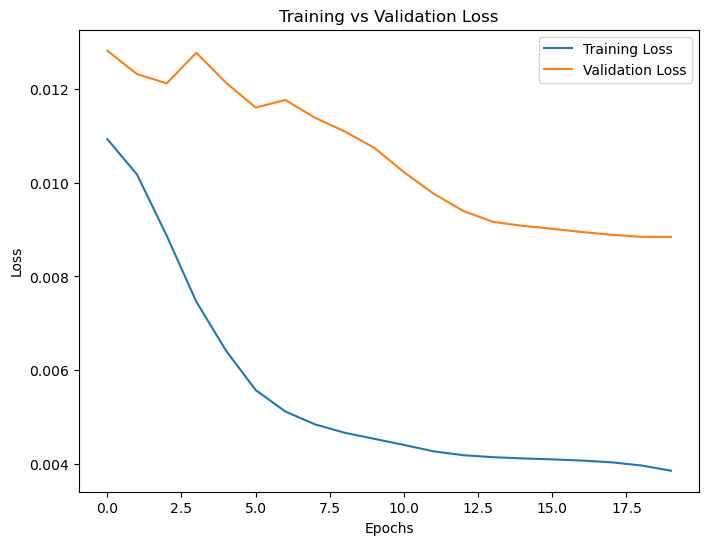

In [9]:
# -----------------------------------------------------------
# 9. PLOT TRAINING AND VALIDATION LOSS
# -----------------------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# -----------------------------------------------------------
# 10. FIND ANOMALY THRESHOLD
#     Higher reconstruction error = anomaly
# -----------------------------------------------------------
def find_threshold(model, x_train_scaled):
    # Reconstruct input
    reconstructed = model.predict(x_train_scaled)

    # Compute reconstruction error
    errors = tf.keras.metrics.msle(reconstructed, x_train_scaled)

    # Mean + Std = threshold
    threshold = np.mean(errors.numpy()) + np.std(errors.numpy())
    return threshold


threshold = find_threshold(model, x_train_scaled)
print("Threshold value:", threshold)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold value: 0.008562278084991087


In [11]:
# -----------------------------------------------------------
# 11. PREDICT ANOMALIES
# -----------------------------------------------------------
def get_predictions(model, x_test_scaled, threshold):
    # Reconstruct input
    reconstructed = model.predict(x_test_scaled)

    # Compute reconstruction error
    errors = tf.keras.losses.msle(reconstructed, x_test_scaled)

    # If error > threshold => anomaly
    anomaly_mask = pd.Series(errors) > threshold

    # Map: True = 0 (anomaly), False = 1 (normal)
    preds = anomaly_mask.map(lambda x: 0.0 if x else 1.0)

    return preds


predictions = get_predictions(model, x_test_scaled, threshold)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [12]:
# -----------------------------------------------------------
# 12. EVALUATE ACCURACY
# -----------------------------------------------------------
accuracy = accuracy_score(predictions, y_test)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.947
